# SYMFLUENCE Tutorial 02b — Basin-Scale Workflow (Bow River at Banff, Semi-Distributed)

## Introduction

This tutorial advances from lumped to semi-distributed watershed modeling. Instead of representing the basin as a single unit, we now subdivide it into multiple connected sub-basins (GRUs) that capture spatial variability while maintaining computational efficiency.

Building on Tutorial 02a's lumped approach, semi-distributed modeling adds spatial detail through automated watershed delineation that creates multiple sub-basins, stream network topology that connects GRUs through routing, and spatially-distributed characteristics that better represent elevation gradients and heterogeneous processes.

The key configuration change is `DOMAIN_DEFINITION_METHOD: 'delineate'` with a `STREAM_THRESHOLD` parameter controlling the number of sub-basins. Smaller thresholds create more GRUs (finer spatial detail) but increase computational cost.

We continue with the **Bow River at Banff** watershed, now discretized into multiple GRUs connected by mizuRoute for explicit stream network routing. This approach improves representation of snowmelt timing, spatial climate variability, and runoff generation patterns.


# Step 1 — Configuration and data reuse

We generate a semi-distributed configuration and intelligently reuse data from Tutorial 02a where possible.

In [1]:
# Step 1 — Semi-distributed configuration with data reuse

from pathlib import Path
import yaml
import shutil
import sys

# Find SYMFLUENCE root by searching upward for 0_config_files directory
def find_symfluence_root():
    current = Path.cwd().resolve()  # Get absolute path
    
    # Search upward, skipping any .ipynb_checkpoints directories
    for i in range(30):  # Search up to 30 levels
        # Skip if this path contains .ipynb_checkpoints
        if '.ipynb_checkpoints' in str(current):
            if current.parent == current:  # Reached filesystem root
                break
            current = current.parent
            continue
            
        # Check if this is the root (has 0_config_files)
        if (current / '0_config_files').exists():
            # Double-check we're not in a checkpoint directory
            if '.ipynb_checkpoints' not in str(current):
                print(f"Found SYMFLUENCE root: {current}")
                return current
            else:
                current = current.parent
                continue
            
        # Move up
        if current.parent == current:  # Reached filesystem root
            break
        current = current.parent
    
    raise FileNotFoundError(f"Could not find SYMFLUENCE root (0_config_files directory). Last path checked: {current}")

SYMFLUENCE_CODE_DIR = find_symfluence_root()

sys.path.append(str(SYMFLUENCE_CODE_DIR))
from symfluence import SYMFLUENCE

# Load template to get the correct SYMFLUENCE_DATA_DIR
config_template = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'
with open(config_template, 'r') as f:
    template_config = yaml.safe_load(f)

# Use SYMFLUENCE_DATA_DIR from template
SYMFLUENCE_DATA_DIR = Path(template_config.get('SYMFLUENCE_DATA_DIR', 
                                                 str(SYMFLUENCE_CODE_DIR.parent / 'data' / 'SYMFLUENCE_data'))).resolve()

print(f"Using SYMFLUENCE_DATA_DIR: {SYMFLUENCE_DATA_DIR}")

# Load template again for config creation
with open(config_template, 'r') as f:
    config = yaml.safe_load(f)

# === Modify for semi-distributed basin ===
config['SYMFLUENCE_CODE_DIR'] = str(SYMFLUENCE_CODE_DIR)
config['SYMFLUENCE_DATA_DIR'] = str(SYMFLUENCE_DATA_DIR)
config['DOMAIN_NAME'] = 'Bow_at_Banff_semi_distributed'
config['EXPERIMENT_ID'] = 'run_1'
config['POUR_POINT_COORDS'] = '51.1722/-115.5717'

# Key changes for semi-distributed
config['DELINEATION_METHOD'] = 'stream_threshold'  # Watershed subdivision
config['DOMAIN_DEFINITION_METHOD'] = 'delineate'  # Watershed
config['STREAM_THRESHOLD'] = 5000  # Controls number of sub-basins
config['DOMAIN_DISCRETIZATION'] = 'GRUs'

config['HYDROLOGICAL_MODEL'] = 'SUMMA'
config['ROUTING_MODEL'] = 'mizuRoute'
config['MIZU_FROM_MODEL'] = 'SUMMA'

config['SETTINGS_MIZU_ROUTING_VAR'] = 'averageRoutedRunoff'
config['SETTINGS_MIZU_ROUTING_UNITS'] = 'm/s'
config['SETTINGS_MIZU_ROUTING_DT'] = '3600'

# Temporal extent
config['EXPERIMENT_TIME_START'] = '2004-01-01 01:00'
config['EXPERIMENT_TIME_END'] = '2007-12-31 23:00'
config['CALIBRATION_PERIOD'] = '2005-10-01, 2006-09-30'
config['EVALUATION_PERIOD'] = '2006-10-01, 2007-12-30'
config['SPINUP_PERIOD'] = '2004-01-01, 2005-09-30'

config['STATION_ID'] = '05BB001'
config['DOWNLOAD_WSC_DATA'] = True

config['PARAMS_TO_CALIBRATE'] = 'minStomatalResistance,cond2photo_slope,vcmax25_canopyTop,jmax25_scale,summerLAI,rootingDepth,soilStressParam,z0Canopy,windReductionParam'
config['OPTIMIZATION_TARGET'] = 'streamflow'
config['ITERATIVE_OPTIMIZATION_ALGORITHM'] = 'DDS'
config['OPTIMIZATION_METRIC'] = 'KGE'
config['CALIBRATION_TIMESTEP'] = 'hourly'  

# Save configuration to 0_config_files directory
config_path = SYMFLUENCE_CODE_DIR / '0_config_files' / 'config_semi_distributed.yaml'
with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"✅ Configuration saved: {config_path}")

# === Data reuse from Tutorial 02a ===
lumped_domain = 'Bow_at_Banff_lumped'
lumped_data_dir = SYMFLUENCE_DATA_DIR / f'domain_{lumped_domain}'

def copy_with_name_adaptation(src, dst, old_name, new_name):
    """Copy directory and adapt filenames"""
    if not src.exists():
        return False
    dst.parent.mkdir(parents=True, exist_ok=True)
    if src.is_file():
        shutil.copy2(src, dst)
        return True
    shutil.copytree(src, dst, dirs_exist_ok=True)
    # Rename files containing old domain name
    for file in dst.rglob('*'):
        if file.is_file() and old_name in file.name:
            new_file = file.parent / file.name.replace(old_name, new_name)
            file.rename(new_file)
    return True

# Initialize SYMFLUENCE first
symfluence = SYMFLUENCE(config_path)
project_dir = symfluence.managers['project'].setup_project()

if lumped_data_dir.exists():
    print(f"\n📋 Reusing data from Tutorial 02a: {lumped_data_dir}")
    
    reusable_data = {
        'Elevation': lumped_data_dir / 'attributes' / 'elevation',
        'Land Cover': lumped_data_dir / 'attributes' / 'landclass',
        'Soils': lumped_data_dir / 'attributes' / 'soilclass',
        'Forcing': lumped_data_dir / 'forcing' / 'raw_data',
        'Streamflow': lumped_data_dir / 'observations' / 'streamflow'
    }
    
    for data_type, src_path in reusable_data.items():
        if src_path.exists():
            rel_path = src_path.relative_to(lumped_data_dir)
            dst_path = project_dir / rel_path
            success = copy_with_name_adaptation(src_path, dst_path, lumped_domain, config['DOMAIN_NAME'])
            if success:
                print(f"   ✅ {data_type}: Copied")
        else:
            print(f"   📋 {data_type}: Not found")
else:
    print(f"\n⚠️  No data from Tutorial 02a found at: {lumped_data_dir}")
    print(f"   Will acquire fresh data.")

# Create pour point
pour_point_path = symfluence.managers['project'].create_pour_point()
print(f"\n✅ Project structure created at: {project_dir}")

Found SYMFLUENCE root: /Users/darrieythorsson/compHydro/code/SYMFLUENCE
Using SYMFLUENCE_DATA_DIR: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data
✅ Configuration saved: /Users/darrieythorsson/compHydro/code/SYMFLUENCE/0_config_files/config_semi_distributed.yaml
2025-12-31 14:48:01 ● SYMFLUENCE Logging Initialized
2025-12-31 14:48:01 ● Domain: Bow_at_Banff_semi_distributed
2025-12-31 14:48:01 ● Experiment ID: run_1
2025-12-31 14:48:01 ● Log Level: INFO
2025-12-31 14:48:01 ● Log File: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/_workLog_Bow_at_Banff_semi_distributed/symfluence_general_Bow_at_Banff_semi_distributed_20251231_144801.log
2025-12-31 14:48:01 ● Configuration logged to: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/_workLog_Bow_at_Banff_semi_distributed/config_Bow_at_Banff_semi_distributed_20251231_144801.yaml
2025-12-31 14:48:01 ● SYMFLUENCE initialized with config: /Users/darrie

## Step 2 — Domain definition (multi-GRU)

Delineate the watershed into multiple sub-basins using stream network analysis and create connected GRUs.

### Step 2a — Attribute check

Verify DEM availability from data reuse, or acquire fresh if needed.

In [2]:
# Step 2a — DEM availability check
dem_path = project_dir / 'attributes' / 'elevation' / 'dem'
if not dem_path.exists() or len(list(dem_path.glob('*.tif'))) == 0:
    print("   DEM not found, acquiring geospatial attributes...")
    # If using MAF supported HPC, uncomment the line below
    # symfluence.managers['data'].acquire_attributes()
    print("✅ Geospatial attributes acquired")
else:
    print("✅ DEM available from previous workflow")

✅ DEM available from previous workflow


### Step 2b — Stream network delineation

Automated watershed subdivision based on stream threshold parameter.

In [3]:
# Step 2b — Stream network delineation
watershed_path = symfluence.managers['domain'].define_domain()
print("✅ Stream network delineation complete")

2025-12-31 14:48:03 ● Domain definition workflow starting with: delineate
2025-12-31 14:48:03 ● Starting geofabric delineation for Bow_at_Banff_semi_distributed using method: stream_threshold
2025-12-31 14:48:03 ● Created interim directory: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/taudem-interim-files/d8
2025-12-31 14:48:03 ● Completed TauDEM common step
2025-12-31 14:48:04 ● Completed TauDEM common step
2025-12-31 14:48:04 ● Completed TauDEM common step
2025-12-31 14:48:04 ● Using threshold-based stream identification
2025-12-31 14:48:05 ● Completed threshold method step
2025-12-31 14:48:05 ● Completed threshold method step
2025-12-31 14:48:05 ● Completed threshold method step
2025-12-31 14:48:06 ● Completed threshold method step
2025-12-31 14:48:06 ● Completed all TauDEM steps
2025-12-31 14:48:06 ● Completed GDAL polygonization using direct method
2025-12-31 14:48:06 ● CRS is not defined for /Users/darrieythorsson/compHydro/data/SYMFL

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/osgeo/gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


2025-12-31 14:48:06 ● Domain map saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/plots/domain/domain_map.png
2025-12-31 14:48:06 ● Domain definition workflow finished
✅ Stream network delineation complete


### Step 2c — GRU discretization

Convert sub-basins to GRUs with routing connectivity.

In [4]:
# Step 2c — GRU discretization
hru_path = symfluence.managers['domain'].discretize_domain()
print("✅ GRU discretization complete")

2025-12-31 14:48:06 ● Discretizing domain using method: GRUs
2025-12-31 14:48:06 ● Starting domain discretization using attributes: ['GRUs']
Step 1/2: Running single attribute discretization method
2025-12-31 14:48:06 ● config domain name Bow_at_Banff_semi_distributed
2025-12-31 14:48:06 ● Calculating mean elevation for each HRU
2025-12-31 14:48:06 ● DEM CRS: EPSG:4326
2025-12-31 14:48:06 ● Shapefile CRS: EPSG:4326
2025-12-31 14:48:06 ● CRS match - no reprojection needed
2025-12-31 14:48:06 ● Successfully calculated elevation statistics for 49 HRUs
2025-12-31 14:48:06 ● Calculated centroids in WGS84: lat range 51.015366 to 51.670480, lon range -116.441298 to -115.575761
2025-12-31 14:48:06 ● GRUs saved as HRUs to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/shapefiles/catchment/Bow_at_Banff_semi_distributed_HRUs_GRUs.shp
2025-12-31 14:48:07 ● HRU plot saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_di

### Step 2d — Network visualization

Visualize the semi-distributed structure: sub-basins and stream network.

Number of GRUs: 49


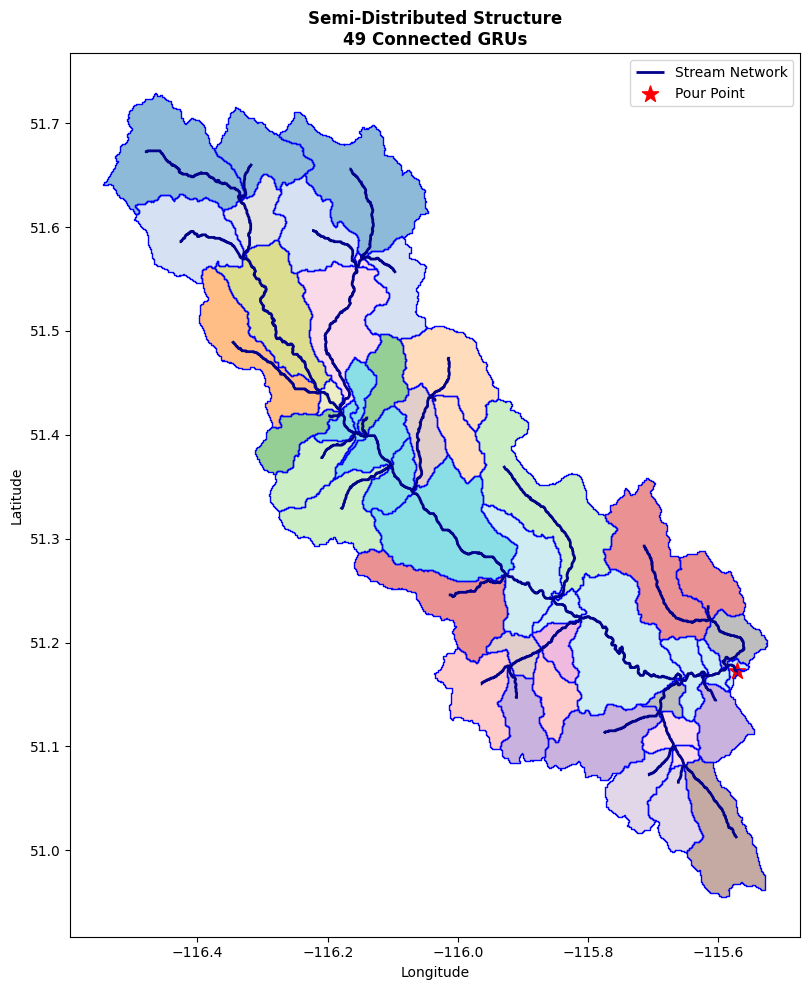

In [5]:
# Step 2d — Network structure visualization

import geopandas as gpd
import matplotlib.pyplot as plt

# Load spatial products
basin_dir = project_dir / 'shapefiles' / 'river_basins'
network_dir = project_dir / 'shapefiles' / 'river_network'

basin_files = list(basin_dir.glob('*.shp'))
network_files = list(network_dir.glob('*.shp'))

if basin_files:
    basins_gdf = gpd.read_file(basin_files[0])
    print(f"Number of GRUs: {len(basins_gdf)}")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    basins_gdf.boundary.plot(ax=ax, color='blue', linewidth=1)
    basins_gdf.plot(ax=ax, column='GRU_ID', cmap='tab20', alpha=0.5, legend=False)
    
    if network_files:
        network_gdf = gpd.read_file(network_files[0])
        network_gdf.plot(ax=ax, color='darkblue', linewidth=2, label='Stream Network')
    
    pour_point_gdf = gpd.read_file(pour_point_path)
    pour_point_gdf.plot(ax=ax, color='red', markersize=150, marker='*', label='Pour Point')
    
    ax.set_title(f'Semi-Distributed Structure\n{len(basins_gdf)} Connected GRUs', fontweight='bold')
    ax.legend()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Basin shapefiles not found")

## Step 3 — Data preprocessing

Process forcing and observation data for multiple GRUs.

In [6]:
# Step 3a — Streamflow observations
# If using MAF supported HPC, uncomment the line below
# symfluence.managers['data'].process_observed_data()
print("✅ Streamflow data processing complete")

✅ Streamflow data processing complete


In [7]:
# Step 3b — Forcing data
# If using MAF supported HPC, uncomment the line below  
# symfluence.managers['data'].acquire_forcings()
print("✅ Forcing acquisition complete")

✅ Forcing acquisition complete


In [8]:
# Step 3c — Model-agnostic preprocessing
symfluence.managers['data'].run_model_agnostic_preprocessing()
print("✅ Model-agnostic preprocessing complete")

2025-12-31 14:48:07 ● Starting model-agnostic preprocessing
2025-12-31 14:48:07 ● Running geospatial statistics
2025-12-31 14:48:07 ● Starting geospatial statistics calculation
2025-12-31 14:48:07 ● Calculating soil statistics
2025-12-31 14:48:07 ● Soil raster CRS: EPSG:4326
2025-12-31 14:48:07 ● Catchment shapefile CRS: EPSG:4326
2025-12-31 14:48:07 ● CRS match - no reprojection needed
2025-12-31 14:48:07 ● Soil statistics saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/shapefiles/catchment_intersection/with_soilgrids/catchment_with_soilclass.shp
2025-12-31 14:48:07 ● Calculating land statistics
2025-12-31 14:48:07 ● Land raster CRS: EPSG:4326
2025-12-31 14:48:07 ● Catchment shapefile CRS: EPSG:4326
2025-12-31 14:48:07 ● CRS match - no reprojection needed
2025-12-31 14:48:07 ● Land statistics saved to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/shapefiles/catchment_intersection/with_land

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_gru_to_seg' to 'S_1_gru_to'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyogrio/raw.

Ended at date and time 2025-12-31 14:48:08.411369
It took 0.297817 seconds to finish creating of the remapping file
---------------------------
The flag to create only remap file is True
The remapping file is either created or given to EASYMORE
The remapping Located here:  /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/temp_easymore_weights/Bow_at_Banff_semi_distributed_ERA5_remapping.nc
2025-12-31 14:48:08 ● Remapping weights created: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/shapefiles/catchment_intersection/with_forcing/Bow_at_Banff_semi_distributed_ERA5_HRU_ID_remapping.nc
2025-12-31 14:48:08 ● Found 0 already processed files
2025-12-31 14:48:08 ● Found 48 files that need processing
2025-12-31 14:48:08 ● Using serial processing (no multiprocessing)
2025-12-31 14:48:08 ● Processing 48 files in serial mode
2025-12-31 14:48:08 ● Processing file 1/48: domain_Bow_at_Banff_semi_distribute

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200401.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200401.nc 
Started at date and time 2025-12-31 14:48:08.436994 
Ended at date and time 2025-12-31 14:48:12.503666 
It took 4.066672 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:12 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200401.nc (1/48)
2025-12-31 14:48:12 ● Processing file 2/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200402.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200402.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200402.nc 
Started at date and time 2025-12-31 14:48:12.526776 
Ended at date and time 2025-12-31 14:48:16.215146 
It took 3.68837 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:16 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200402.nc (2/48)
2025-12-31 14:48:16 ● Processing file 3/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200403.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the v

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200403.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200403.nc 
Started at date and time 2025-12-31 14:48:16.238575 
Ended at date and time 2025-12-31 14:48:20.233872 
It took 3.995297 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:20 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200403.nc (3/48)
2025-12-31 14:48:20 ● Processing file 4/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200404.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200404.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200404.nc 
Started at date and time 2025-12-31 14:48:20.258370 
Ended at date and time 2025-12-31 14:48:24.336136 
It took 4.077766 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:24 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200404.nc (4/48)
2025-12-31 14:48:24 ● Processing file 5/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200405.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200405.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200405.nc 
Started at date and time 2025-12-31 14:48:24.360404 
Ended at date and time 2025-12-31 14:48:28.472698 
It took 4.112294 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:28 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200405.nc (5/48)
2025-12-31 14:48:28 ● Processing file 6/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200406.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200406.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200406.nc 
Started at date and time 2025-12-31 14:48:28.496444 
Ended at date and time 2025-12-31 14:48:32.367368 
It took 3.870924 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:32 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200406.nc (6/48)
2025-12-31 14:48:32 ● Processing file 7/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200407.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200407.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200407.nc 
Started at date and time 2025-12-31 14:48:32.392467 
Ended at date and time 2025-12-31 14:48:36.454939 
It took 4.062472 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:36 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200407.nc (7/48)
2025-12-31 14:48:36 ● Processing file 8/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200408.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200408.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200408.nc 
Started at date and time 2025-12-31 14:48:36.477995 
Ended at date and time 2025-12-31 14:48:40.497874 
It took 4.019879 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:40 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200408.nc (8/48)
2025-12-31 14:48:40 ● Processing file 9/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200409.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200409.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200409.nc 
Started at date and time 2025-12-31 14:48:40.525601 
Ended at date and time 2025-12-31 14:48:44.650441 
It took 4.12484 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:44 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200409.nc (9/48)
2025-12-31 14:48:44 ● Processing file 10/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200410.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200410.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200410.nc 
Started at date and time 2025-12-31 14:48:44.675185 
Ended at date and time 2025-12-31 14:48:48.891025 
It took 4.21584 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:48 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200410.nc (10/48)
2025-12-31 14:48:48 ● Progress: 10/48 files processed (10 successful)
2025-12-31 14:48:48 ● Processing file 11/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200411.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200411.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200411.nc 
Started at date and time 2025-12-31 14:48:48.916687 
Ended at date and time 2025-12-31 14:48:52.961883 
It took 4.045196 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:52 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200411.nc (11/48)
2025-12-31 14:48:52 ● Processing file 12/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200412.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200412.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200412.nc 
Started at date and time 2025-12-31 14:48:52.986001 
Ended at date and time 2025-12-31 14:48:57.178252 
It took 4.192251 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:48:57 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200412.nc (12/48)
2025-12-31 14:48:57 ● Processing file 13/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200501.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200501.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200501.nc 
Started at date and time 2025-12-31 14:48:57.204100 
Ended at date and time 2025-12-31 14:49:01.490088 
It took 4.285988 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:01 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200501.nc (13/48)
2025-12-31 14:49:01 ● Processing file 14/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200502.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200502.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200502.nc 
Started at date and time 2025-12-31 14:49:01.515746 
Ended at date and time 2025-12-31 14:49:05.340811 
It took 3.825065 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:05 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200502.nc (14/48)
2025-12-31 14:49:05 ● Processing file 15/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200503.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200503.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200503.nc 
Started at date and time 2025-12-31 14:49:05.365009 
Ended at date and time 2025-12-31 14:49:09.604853 
It took 4.239844 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:09 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200503.nc (15/48)
2025-12-31 14:49:09 ● Processing file 16/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200504.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200504.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200504.nc 
Started at date and time 2025-12-31 14:49:09.630339 
Ended at date and time 2025-12-31 14:49:13.698950 
It took 4.068611 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:13 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200504.nc (16/48)
2025-12-31 14:49:13 ● Processing file 17/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200505.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200505.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200505.nc 
Started at date and time 2025-12-31 14:49:13.724326 
Ended at date and time 2025-12-31 14:49:17.908822 
It took 4.184496 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:17 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200505.nc (17/48)
2025-12-31 14:49:17 ● Processing file 18/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200506.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200506.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200506.nc 
Started at date and time 2025-12-31 14:49:17.934173 
Ended at date and time 2025-12-31 14:49:21.913512 
It took 3.979339 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:21 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200506.nc (18/48)
2025-12-31 14:49:21 ● Processing file 19/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200507.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200507.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200507.nc 
Started at date and time 2025-12-31 14:49:21.937908 
Ended at date and time 2025-12-31 14:49:26.107584 
It took 4.169676 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:26 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200507.nc (19/48)
2025-12-31 14:49:26 ● Processing file 20/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200508.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200508.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200508.nc 
Started at date and time 2025-12-31 14:49:26.131645 
Ended at date and time 2025-12-31 14:49:30.298170 
It took 4.166525 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:30 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200508.nc (20/48)
2025-12-31 14:49:30 ● Progress: 20/48 files processed (20 successful)
2025-12-31 14:49:30 ● Processing file 21/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200509.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200509.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200509.nc 
Started at date and time 2025-12-31 14:49:30.321803 
Ended at date and time 2025-12-31 14:49:34.320447 
It took 3.998644 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:34 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200509.nc (21/48)
2025-12-31 14:49:34 ● Processing file 22/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200510.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200510.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200510.nc 
Started at date and time 2025-12-31 14:49:34.345506 
Ended at date and time 2025-12-31 14:49:38.558570 
It took 4.213064 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:38 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200510.nc (22/48)
2025-12-31 14:49:38 ● Processing file 23/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200511.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200511.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200511.nc 
Started at date and time 2025-12-31 14:49:38.586577 
Ended at date and time 2025-12-31 14:49:42.642921 
It took 4.056344 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:42 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200511.nc (23/48)
2025-12-31 14:49:42 ● Processing file 24/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200512.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200512.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200512.nc 
Started at date and time 2025-12-31 14:49:42.669356 
Ended at date and time 2025-12-31 14:49:46.906478 
It took 4.237122 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:46 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200512.nc (24/48)
2025-12-31 14:49:46 ● Processing file 25/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200601.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200601.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200601.nc 
Started at date and time 2025-12-31 14:49:46.932441 
Ended at date and time 2025-12-31 14:49:51.123128 
It took 4.190687 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:51 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200601.nc (25/48)
2025-12-31 14:49:51 ● Processing file 26/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200602.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200602.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200602.nc 
Started at date and time 2025-12-31 14:49:51.148029 
Ended at date and time 2025-12-31 14:49:54.902829 
It took 3.7548 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:54 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200602.nc (26/48)
2025-12-31 14:49:54 ● Processing file 27/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200603.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the 

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200603.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200603.nc 
Started at date and time 2025-12-31 14:49:54.927115 
Ended at date and time 2025-12-31 14:49:59.172644 
It took 4.245529 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:49:59 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200603.nc (27/48)
2025-12-31 14:49:59 ● Processing file 28/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200604.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200604.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200604.nc 
Started at date and time 2025-12-31 14:49:59.197007 
Ended at date and time 2025-12-31 14:50:03.126589 
It took 3.929582 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:03 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200604.nc (28/48)
2025-12-31 14:50:03 ● Processing file 29/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200605.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200605.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200605.nc 
Started at date and time 2025-12-31 14:50:03.150957 
Ended at date and time 2025-12-31 14:50:07.568142 
It took 4.417185 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:07 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200605.nc (29/48)
2025-12-31 14:50:07 ● Processing file 30/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200606.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200606.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200606.nc 
Started at date and time 2025-12-31 14:50:07.594425 
Ended at date and time 2025-12-31 14:50:11.678411 
It took 4.083986 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:11 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200606.nc (30/48)
2025-12-31 14:50:11 ● Progress: 30/48 files processed (30 successful)
2025-12-31 14:50:11 ● Processing file 31/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200607.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200607.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200607.nc 
Started at date and time 2025-12-31 14:50:11.704039 
Ended at date and time 2025-12-31 14:50:15.872157 
It took 4.168118 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:15 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200607.nc (31/48)
2025-12-31 14:50:15 ● Processing file 32/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200608.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200608.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200608.nc 
Started at date and time 2025-12-31 14:50:15.898072 
Ended at date and time 2025-12-31 14:50:20.035411 
It took 4.137339 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:20 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200608.nc (32/48)
2025-12-31 14:50:20 ● Processing file 33/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200609.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200609.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200609.nc 
Started at date and time 2025-12-31 14:50:20.060919 
Ended at date and time 2025-12-31 14:50:23.960785 
It took 3.899866 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:23 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200609.nc (33/48)
2025-12-31 14:50:23 ● Processing file 34/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200610.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200610.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200610.nc 
Started at date and time 2025-12-31 14:50:23.985418 
Ended at date and time 2025-12-31 14:50:27.963468 
It took 3.97805 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:27 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200610.nc (34/48)
2025-12-31 14:50:27 ● Processing file 35/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200611.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200611.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200611.nc 
Started at date and time 2025-12-31 14:50:27.989525 
Ended at date and time 2025-12-31 14:50:32.322514 
It took 4.332989 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:32 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200611.nc (35/48)
2025-12-31 14:50:32 ● Processing file 36/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200612.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200612.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200612.nc 
Started at date and time 2025-12-31 14:50:32.351760 
Ended at date and time 2025-12-31 14:50:36.442335 
It took 4.090575 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:36 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200612.nc (36/48)
2025-12-31 14:50:36 ● Processing file 37/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200701.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200701.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200701.nc 
Started at date and time 2025-12-31 14:50:36.467337 
Ended at date and time 2025-12-31 14:50:40.873056 
It took 4.405719 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:40 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200701.nc (37/48)
2025-12-31 14:50:40 ● Processing file 38/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200702.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200702.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200702.nc 
Started at date and time 2025-12-31 14:50:40.900395 
Ended at date and time 2025-12-31 14:50:44.696484 
It took 3.796089 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:44 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200702.nc (38/48)
2025-12-31 14:50:44 ● Processing file 39/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200703.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200703.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200703.nc 
Started at date and time 2025-12-31 14:50:44.720559 
Ended at date and time 2025-12-31 14:50:48.911786 
It took 4.191227 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:48 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200703.nc (39/48)
2025-12-31 14:50:48 ● Processing file 40/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200704.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200704.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200704.nc 
Started at date and time 2025-12-31 14:50:48.937429 
Ended at date and time 2025-12-31 14:50:52.877388 
It took 3.939959 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:52 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200704.nc (40/48)
2025-12-31 14:50:52 ● Progress: 40/48 files processed (40 successful)
2025-12-31 14:50:52 ● Processing file 41/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200705.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200705.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200705.nc 
Started at date and time 2025-12-31 14:50:52.903761 
Ended at date and time 2025-12-31 14:50:57.055634 
It took 4.151873 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:50:57 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200705.nc (41/48)
2025-12-31 14:50:57 ● Processing file 42/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200706.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200706.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200706.nc 
Started at date and time 2025-12-31 14:50:57.083727 
Ended at date and time 2025-12-31 14:51:01.031799 
It took 3.948072 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:01 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200706.nc (42/48)
2025-12-31 14:51:01 ● Processing file 43/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200707.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200707.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200707.nc 
Started at date and time 2025-12-31 14:51:01.056898 
Ended at date and time 2025-12-31 14:51:05.089067 
It took 4.032169 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:05 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200707.nc (43/48)
2025-12-31 14:51:05 ● Processing file 44/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200708.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200708.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200708.nc 
Started at date and time 2025-12-31 14:51:05.113407 
Ended at date and time 2025-12-31 14:51:09.130699 
It took 4.017292 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:09 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200708.nc (44/48)
2025-12-31 14:51:09 ● Processing file 45/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200709.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200709.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200709.nc 
Started at date and time 2025-12-31 14:51:09.155203 
Ended at date and time 2025-12-31 14:51:13.046252 
It took 3.891049 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:13 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200709.nc (45/48)
2025-12-31 14:51:13 ● Processing file 46/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200710.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200710.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200710.nc 
Started at date and time 2025-12-31 14:51:13.070853 
Ended at date and time 2025-12-31 14:51:17.092318 
It took 4.021465 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:17 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200710.nc (46/48)
2025-12-31 14:51:17 ● Processing file 47/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200711.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200711.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200711.nc 
Started at date and time 2025-12-31 14:51:17.116747 
Ended at date and time 2025-12-31 14:51:21.008986 
It took 3.892239 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:21 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200711.nc (47/48)
2025-12-31 14:51:21 ● Processing file 48/48: domain_Bow_at_Banff_semi_distributed_ERA5_merged_200712.nc
EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all th

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:939: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat_value = np.array(ncid.variables[self.var_lat])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/easymore/remapper.py:940: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lon_value = np.array(ncid.variables[self.var_lon])
/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.

Remapping /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/raw_data/domain_Bow_at_Banff_semi_distributed_ERA5_merged_200712.nc to /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/forcing/basin_averaged_data/Bow_at_Banff_semi_distributed_ERA5_remapped_domain_Bow_at_Banff_semi_distributed_ERA5_merged_200712.nc 
Started at date and time 2025-12-31 14:51:21.034675 
Ended at date and time 2025-12-31 14:51:25.058354 
It took 4.023679 seconds to finish the remapping of variable(s) 
---------------------
---------------------
14:51:25 ● ✓ Successfully processed domain_Bow_at_Banff_semi_distributed_ERA5_merged_200712.nc (48/48)
2025-12-31 14:51:25 ● Processing complete: 48 files processed successfully out of 48
2025-12-31 14:51:25 ● Total files processed or skipped: 48 out of 48
2025-12-31 14:51:25 ● Forcing remapping process completed
2025-12-31 14:51:25 ● Forcing data resampling process completed
2025-

## Step 4 — Model execution

Configure and run SUMMA-mizuRoute with multiple connected GRUs.

In [9]:
# Step 4a — Model configuration
symfluence.managers['model'].preprocess_models()
print("✅ Semi-distributed model configuration complete")

2025-12-31 14:51:25 ● Starting model-specific preprocessing
2025-12-31 14:51:25 ● Starting SUMMA spatial preprocessing
2025-12-31 14:51:25 ● Starting memory-efficient temperature lapse rate and data step application
2025-12-31 14:51:25 ● Converting /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/shapefiles/catchment_intersection/with_forcing/Bow_at_Banff_semi_distributed_ERA5_intersected_shapefile.shp to CSV format
2025-12-31 14:51:25 ● Successfully created /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/shapefiles/catchment_intersection/with_forcing/Bow_at_Banff_semi_distributed_ERA5_intersected_shapefile.csv
2025-12-31 14:51:25 ● Loading topology data...
2025-12-31 14:51:25 ● Loaded topology data: 102 rows, 0.64 MB
2025-12-31 14:51:25 ● Found 48 forcing files to process
2025-12-31 14:51:25 ● Pre-calculating lapse rate corrections...
2025-12-31 14:51:25 ● Prepared lapse corrections for 49 HRUs
2025-1

/Users/darrieythorsson/compHydro/code/SYMFLUENCE/venv/lib/python3.11/site-packages/pyproj/transformer.py:816: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


In [ ]:
# Step 4b — Model execution
print(f"Running {config['HYDROLOGICAL_MODEL']} with {config['ROUTING_MODEL']} ({len(basins_gdf)} GRUs)...")
symfluence.managers['model'].run_models()
print("✅ Semi-distributed simulation complete")

Running SUMMA with mizuRoute (49 GRUs)...
2025-12-31 14:51:30 ● Starting model runs
2025-12-31 14:51:30 ● Running model: SUMMA
2025-12-31 14:51:30 ● Starting SUMMA run
2025-12-31 14:51:30 ● Running SUMMA with LD_LIBRARY_PATH: 
2025-12-31 14:51:30 ● SUMMA binary: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/installs/summa/bin/summa_sundials.exe
2025-12-31 14:51:30 ● File manager: /Users/darrieythorsson/compHydro/data/SYMFLUENCE_data/domain_Bow_at_Banff_semi_distributed/settings/SUMMA/fileManager.txt


## Step 5 — Evaluation

Compare semi-distributed results against observations.

In [ ]:
# Step 5 — Semi-distributed evaluation

import pandas as pd
import numpy as np
import xarray as xr

# --- 1) Observations (make daily & tz-naive) ---
obs_path = project_dir / "observations" / "streamflow" / "preprocessed" / f"{config['DOMAIN_NAME']}_streamflow_processed.csv"
obs_df = pd.read_csv(obs_path, parse_dates=["datetime"]).set_index("datetime").sort_index()
# If tz-aware, make tz-naive for matching
if obs_df.index.tz is not None:
    obs_df.index = obs_df.index.tz_convert(None)
# Put obs on daily mean (adjust if your obs are daily totals/instants)
obs_daily = obs_df["discharge_cms"].resample("D").mean().rename("discharge_obs")

# --- 2) Routed simulation: select the gauge segment & make daily ---
routing_dir = project_dir / "simulations" / config["EXPERIMENT_ID"] / "mizuRoute"
sim_files = list(routing_dir.glob("*.nc"))
if not sim_files:
    raise FileNotFoundError(f"No routed streamflow in: {routing_dir}")

ds = xr.open_dataset(sim_files[0])

# --- Auto-pick the segment with the highest flow ---
var = ds["IRFroutedRunoff"]

# Identify time and segment dims robustly
time_dim = next((d for d in var.dims if "time" in d.lower()), None)
if time_dim is None:
    raise RuntimeError("Could not find a time dimension in IRFroutedRunoff.")

seg_dims = [d for d in var.dims if d != time_dim]
if len(seg_dims) == 0:
    # 1D over time (no segment dimension) -> just use it
    sim_series = var
else:
    # Assume single segment dimension; if multiple, just take the first
    seg_dim = seg_dims[0]

    # Compute mean over time per segment (skip NaNs), pick the largest
    seg_mean = var.mean(time_dim, skipna=True)
    # argmax returns an index along seg_dim
    max_idx = seg_mean.argmax(dim=seg_dim)

    # Get the coordinate value (segment id) at that index
    seg_id = seg_mean[seg_dim].isel({seg_dim: max_idx}).item()

    # Select that segment’s time series
    sim_series = var.sel({seg_dim: seg_id})

    # Optional: quick sanity log
    print(f"Selected segment dim: {seg_dim}, id: {seg_id}")
    try:
        print("Segment mean flow (m^3/s):", float(seg_mean.sel({seg_dim: seg_id}).values))
    except Exception:
        pass


# Convert to pandas
sim_df = sim_series.to_series().sort_index()
# Make tz-naive if needed
if getattr(sim_df.index, "tz", None) is not None:
    sim_df.index = sim_df.index.tz_convert(None)

# Put sim on daily mean to match obs cadence (change to .sum() if routed values are volumes)
sim_daily = sim_df.resample("D").mean().rename("discharge_sim")

# --- 3) Align & join on dates we actually have in obs ---


spinup_end = (sim_daily.index.min() + pd.DateOffset(years=1)).normalize()



# Trim
obs_daily_trim = obs_daily.loc[obs_daily.index >= spinup_end]
sim_daily_trim = sim_daily.loc[sim_daily.index >= spinup_end]

# Rebuild evaluation frame
eval_df = pd.concat([obs_daily_trim.rename("discharge_obs"),
                     sim_daily_trim.rename("discharge_sim")], axis=1) \
             .dropna(subset=["discharge_obs", "discharge_sim"]) \
             .sort_index()

# Short-circuit if empty
if eval_df.empty:
    raise RuntimeError("After spinup trimming there is no overlap. Check your spinup_end rule/time ranges.")

obs_valid = eval_df["discharge_obs"]
sim_valid = eval_df["discharge_sim"]

# --- 4) Robust metrics ---
def _safe_div(a, b):
    return np.nan if b == 0 or np.isnan(b) else a / b

def nse(obs, sim):
    num = np.nansum((obs - sim) ** 2)
    den = np.nansum((obs - np.nanmean(obs)) ** 2)
    return float(1 - _safe_div(num, den))

def kge(obs, sim):
    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.nanstd(sim) / np.nanstd(obs)
    beta = np.nanmean(sim) / np.nanmean(obs)
    return float(1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2))

def pbias(obs, sim):
    num = np.nansum(sim - obs)
    den = np.nansum(obs)
    return float(100 * _safe_div(num, den))

nse_val = np.round(nse(obs_valid, sim_valid), 3)
kge_val = np.round(kge(obs_valid, sim_valid), 3)
pbias_val = np.round(pbias(obs_valid, sim_valid), 1)

print(f"Performance Metrics:")
print(f"  NSE: {nse_val}")
print(f"  KGE: {kge_val}")
print(f"  PBIAS: {pbias_val}%")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series
axes[0, 0].plot(obs_valid.index, obs_valid.values, 'b-', label='Observed', linewidth=1.2, alpha=0.7)
axes[0, 0].plot(sim_valid.index, sim_valid.values, 'r-', label=f'Semi-Distributed ({len(basins_gdf)} GRUs)', 
                linewidth=1.2, alpha=0.7)
axes[0, 0].set_ylabel('Discharge (m³/s)')
axes[0, 0].set_title('Semi-Distributed Streamflow')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.95, f"NSE: {nse_val}\nKGE: {kge_val}\nBias: {pbias_val}%\nGRUs: {len(basins_gdf)}",
                transform=axes[0, 0].transAxes, verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8), fontsize=9)

# Scatter
axes[0, 1].scatter(obs_valid, sim_valid, alpha=0.5, s=10, c='green')
max_val = max(obs_valid.max(), sim_valid.max())
axes[0, 1].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
axes[0, 1].set_xlabel('Observed (m³/s)')
axes[0, 1].set_ylabel('Simulated (m³/s)')
axes[0, 1].set_title('Observed vs Simulated')
axes[0, 1].grid(True, alpha=0.3)

# Monthly climatology
monthly_obs = obs_valid.groupby(obs_valid.index.month).mean()
monthly_sim = sim_valid.groupby(sim_valid.index.month).mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1, 0].plot(monthly_obs.index, monthly_obs.values, 'b-o', label='Observed', markersize=6)
axes[1, 0].plot(monthly_sim.index, monthly_sim.values, 'r-o', label='Simulated', markersize=6)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names)
axes[1, 0].set_ylabel('Mean Discharge (m³/s)')
axes[1, 0].set_title('Seasonal Flow Regime')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Flow duration curve
obs_sorted = obs_valid.sort_values(ascending=False)
sim_sorted = sim_valid.sort_values(ascending=False)
obs_ranks = np.arange(1., len(obs_sorted) + 1) / len(obs_sorted) * 100
sim_ranks = np.arange(1., len(sim_sorted) + 1) / len(sim_sorted) * 100
axes[1, 1].semilogy(obs_ranks, obs_sorted, 'b-', label='Observed', linewidth=2)
axes[1, 1].semilogy(sim_ranks, sim_sorted, 'r-', label='Simulated', linewidth=2)
axes[1, 1].set_xlabel('Exceedance Probability (%)')
axes[1, 1].set_ylabel('Discharge (m³/s)')
axes[1, 1].set_title('Flow Duration Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Semi-Distributed Evaluation — {config["DOMAIN_NAME"]} ({len(basins_gdf)} GRUs)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Semi-distributed evaluation complete")

# Step 5b — Run calibration 



In [ ]:
results_file = symfluence.managers['optimization'].calibrate_model()  
print("Calibration results file:", results_file)